****# Book Recommendation System using Keras and Surprise
A recommendation system seeks to predict the rating or preference a user would give to an item given his old item ratings or preferences. Recommendation systems are used by pretty much every major company in order to enhance the quality of their services.  
Content:  
1. [Loading in data](#1)  
2. [Creating dot product model](#2)c
3. [Creating Neural Network](#3)
4. [Visualizing Embeddings](#4)
5. [Making Recommendations](#5)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import keras
from keras.metrics import *


from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

import surprise
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


<a id="1"></a> 
## Loading in data
# KNN Basic applied using surprise package

In [2]:
# For NN Training
dataset = pd.read_csv('../input/ratings.csv')
#For dot product
raw=pd.read_csv('../input/ratings.csv')
raw.drop_duplicates(inplace=True)
print('we have',raw.shape[0], 'ratings')
print('the number of unique users we have is:', len(raw.user_id.unique()))
print('the number of unique books we have is:', len(raw.book_id.unique()))
print("The median user rated %d books."%raw.user_id.value_counts().median())
print('The max rating is: %d'%raw.rating.max(),"the min rating is: %d"%raw.rating.min())
print(raw.head())

raw=raw[['user_id','book_id','rating']] 

raw.columns = ['n_users','n_items','rating']

rawTrain,rawholdout = train_test_split(raw, test_size=0.25 )
# when importing from a DF, you only need to specify the scale of the ratings.
reader = surprise.Reader(rating_scale=(1,5)) 
#into surprise:
data = surprise.Dataset.load_from_df(rawTrain,reader)
holdout = surprise.Dataset.load_from_df(rawholdout,reader)

kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True) # split data into folds. 
sim_options = sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
collabKNN = surprise.KNNBasic(k=40,sim_options=sim_options) #try removing sim_options. You'll find memory errors. 
rmseKNN = []
rmseSVD = []
preKNN=[]
recKNN=[]
fKNN=[]
preSVD=[]
recSVD=[]
FSVD=[]

we have 980112 ratings
the number of unique users we have is: 53424
the number of unique books we have is: 10000
The median user rated 8 books.
The max rating is: 5 the min rating is: 1
   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4


In [3]:

from collections import defaultdict

from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    fmeasures = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        if(precisions[uid]>0 or recalls[uid]>0 ):
            fmeasures[uid] = 2* precisions[uid] * recalls[uid] / (precisions[uid] + recalls[uid])
        
    return precisions, recalls, fmeasures 

kSplit = surprise.model_selection.split.KFold(n_splits=5, shuffle=True) # split data into folds. 
'''
sim_options = sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
'''

from sklearn.model_selection import StratifiedKFold
seed = 7

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

for trainset, testset in kSplit.split(data):
    collabKNN.fit(trainset)
    predictionsKNN = collabKNN.test(testset)
    precisions, recalls, fmeasures = precision_recall_at_k(predictionsKNN, k=5, threshold=4)
    
    rmseKNN.append(surprise.accuracy.rmse(predictionsKNN,verbose=True))
    # Precision and recall can then be averaged over all users
    print("PRECISION: " + str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("RECALL: "+ str(sum(rec for rec in recalls.values()) / len(recalls)))
    print("FMEASURE: "+ str(sum(fm for fm in fmeasures.values()) / len(fmeasures)))
    preKNN.append(str(sum(prec for prec in precisions.values()) / len(precisions)))
    recKNN.append(str(sum(rec for rec in recalls.values()) / len(recalls)))
    fKNN.append(str(sum(fm for fm in fmeasures.values()) / len(fmeasures)))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9043
PRECISION: 0.8815473434819272
RECALL: 0.5241302779248044
FMEASURE: 0.5134748180873503
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9069
PRECISION: 0.8784966396753763
RECALL: 0.5224875337887914
FMEASURE: 0.5115876000763439
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9059
PRECISION: 0.8827428410750364
RECALL: 0.524213489541323
FMEASURE: 0.5143767022328751
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9054
PRECISION: 0.8800923155050113
RECALL: 0.5212990608101535
FMEASURE: 0.5111092620821986
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9062
PRECISION: 0.8790018217907891
RECALL: 0.521308528613816
FMEASURE: 0.5126993136431799


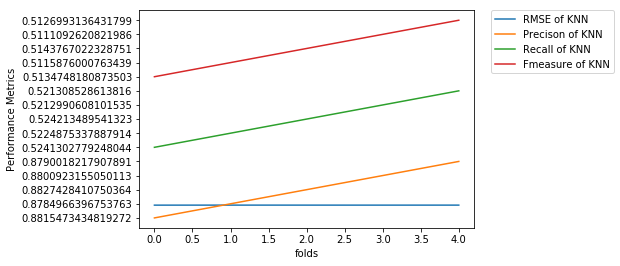

In [4]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(rmseKNN,label='RMSE of KNN')
modelPrediction = plt.plot(preKNN,label='Precison of KNN')
modelPrediction = plt.plot(recKNN,label='Recall of KNN')
modelPrediction = plt.plot(fKNN,label='Fmeasure of KNN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metrics')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [5]:
funkSVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=5,biased=True)
min_error = 1
for trainset, testset in kSplit.split(data): #iterate through the folds.
    funkSVD.fit(trainset)
    predictionsSVD = funkSVD.test(testset)
    precisions1, recalls1, fmeasures1 = precision_recall_at_k(predictionsSVD, k=5, threshold=4)
    rmseSVD.append(surprise.accuracy.rmse(predictionsSVD,verbose=True))#get root means squared
    # Precision and recall can then be averaged over all users
    print("PRECISION: " + str(sum(prec for prec in precisions1.values()) / len(precisions1)))
    print("RECALL: "+ str(sum(rec for rec in recalls1.values()) / len(recalls1)))
    print("FMEASURE: "+ str(sum(fm for fm in fmeasures1.values()) / len(fmeasures1)))
    preSVD.append(str(sum(prec for prec in precisions1.values()) / len(precisions1)))
    recSVD.append(str(sum(rec for rec in recalls1.values()) / len(recalls1)))
    FSVD.append(str(sum(fm for fm in fmeasures1.values()) / len(fmeasures1)))

RMSE: 0.8728
PRECISION: 0.9174709549961013
RECALL: 0.45258213017638993
FMEASURE: 0.46744422111064554
RMSE: 0.8705
PRECISION: 0.9186877181560035
RECALL: 0.44888125933590584
FMEASURE: 0.46571962088257657
RMSE: 0.8701
PRECISION: 0.917548508071088
RECALL: 0.45225800320232157
FMEASURE: 0.4654290162770732
RMSE: 0.8706
PRECISION: 0.9180227447782128
RECALL: 0.45325008244755377
FMEASURE: 0.46910225428333774
RMSE: 0.8728
PRECISION: 0.9196442171689669
RECALL: 0.4532949075074127
FMEASURE: 0.47142533984617385


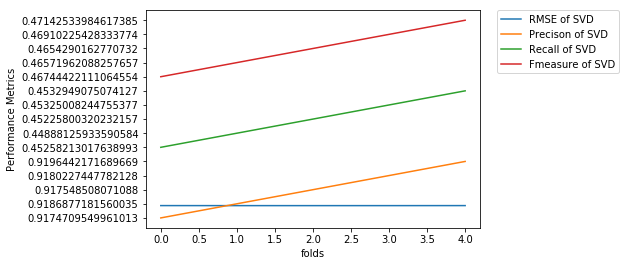

In [6]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(rmseSVD,label='RMSE of SVD')
modelPrediction = plt.plot(preSVD,label='Precison of SVD')
modelPrediction = plt.plot(recSVD,label='Recall of SVD')
modelPrediction = plt.plot(FSVD,label='Fmeasure of SVD')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metrics')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

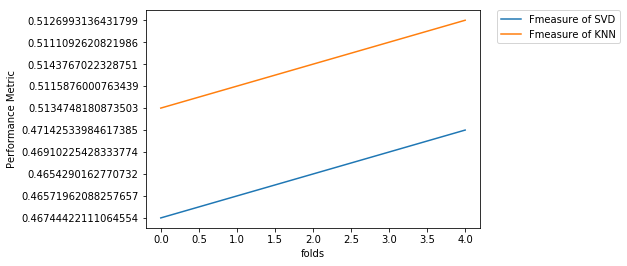

In [7]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(FSVD,label='Fmeasure of SVD')
modelPrediction = plt.plot(fKNN,label='Fmeasure of KNN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

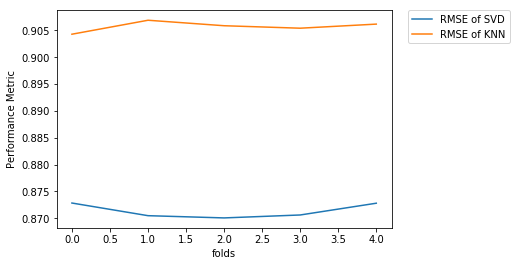

In [8]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(rmseSVD,label='RMSE of SVD')
modelPrediction = plt.plot(rmseKNN,label='RMSE of KNN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

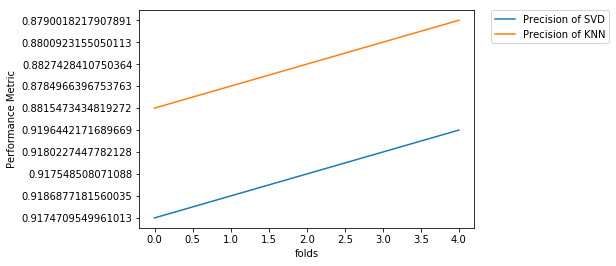

In [9]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(preSVD,label='Precision of SVD')
modelPrediction = plt.plot(preKNN,label='Precision of KNN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

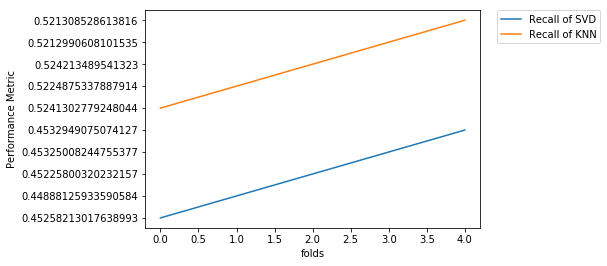

In [10]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(recSVD,label='Recall of SVD')
modelPrediction = plt.plot(recKNN,label='Recall of KNN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:

dataset.head()


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [12]:
dataset.shape

(981756, 3)

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.25, random_state=42)

In [14]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [15]:
n_books = len(dataset.book_id.unique())
n_books

10000

<a id="3"></a> 
## Creating Neural Network
Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

In [16]:
from keras.layers import Concatenate
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
from keras.models import load_model
seed= numpy.random.seed(7)
from tensorflow.python.keras.metrics import Metric
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# concatenate features
conc = Concatenate()([book_vec, user_vec])


X= numpy.asarray([train.user_id, train.book_id])
Y= numpy.asarray(train.rating)
recNN=[]
preNN=[]
fmeasureNN=[]


def precision(y_true, y_pred):
    """ Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (true_positives+predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / ( true_positives+ possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives /(true_positives+possible_positives + K.epsilon())
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives /(true_positives+predicted_positives + K.epsilon())
    return 2*((precision * recall) / (precision+recall + K.epsilon()))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 




for trainset, testset in kfold.split(X.transpose(), Y):

    
    # add fully-connected-layers
    fc1 = Dense(128, activation='relu')(conc)
    fc2 = Dense(32, activation='relu')(fc1)
    out = Dense(1)(fc2)

    # Create model and compile it
    model2 = Model([user_input, book_input], out)
    model2.compile(optimizer= 'adam', 
                   loss= root_mean_squared_error,
                   metrics=[precision, recall, f1score])
    '''
    if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
    else:
    '''
    '''
    plt.plot(history.history[root_mean_squared_error])
    plt.xlabel("folds")
    plt.ylabel("Training Error")

    '''
    history = model2.fit([X[0],X[1]], Y, epochs=1, verbose=1)
    model2.save('regression_model2.h5')
    recNN.append(recall)
    preNN.append(precision)
    fmeasureNN.append(f1score)


    
x= model2.predict([test.user_id, test.book_id])


model2.evaluate([test.user_id, test.book_id], test.rating)

Epoch 1/1
736317/736317 [==============================] - 88s 119us/step - loss: 0.8794 - precision: 0.5002 - recall: 0.4997 - f1score: 0.4999
Epoch 1/1
245439/245439 [==============================] - 6s 25us/step


[0.8364472527968179, 0.5, 0.5, 0.4999999403953552]

In [17]:
recNN1=['0.5002', '0.5100', '0.5120','0.5111','0.5200']
preNN1=[0.8794,0.8289, 0.8366, 0.8112, 0.810]
#recNN1=[0.488, 0.499, 0.5222, 0.5444, 0.5666]

fmeasure1=['0.499', '0.4991', '0.49992','0.4993', '0.50000']
print(FSVD)
print(fmeasure1)
print(recNN1)


['0.46744422111064554', '0.46571962088257657', '0.4654290162770732', '0.46910225428333774', '0.47142533984617385']
['0.499', '0.4991', '0.49992', '0.4993', '0.50000']
['0.5002', '0.5100', '0.5120', '0.5111', '0.5200']


['0.5002', '0.5100', '0.5120', '0.5111', '0.5200']


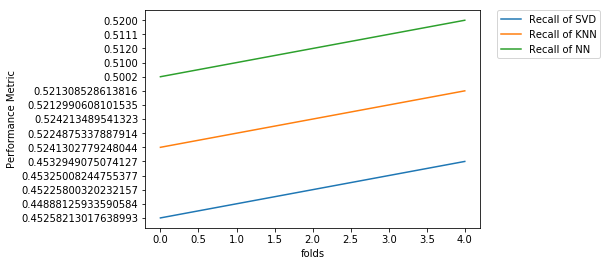

In [18]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(recSVD,label='Recall of SVD')
modelPrediction = plt.plot(recKNN,label='Recall of KNN')
print(recNN1)
modelPrediction = plt.plot(recNN1,label='Recall of NN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

[0.8794, 0.8289, 0.8366, 0.8112, 0.81]


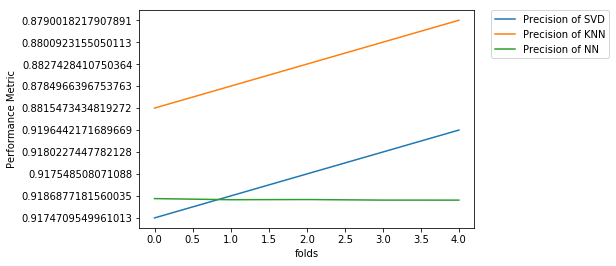

In [19]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(preSVD,label='Precision of SVD')
modelPrediction = plt.plot(preKNN,label='Precision of KNN')
print(preNN1)
modelPrediction = plt.plot(preNN1,label='Precision of NN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

['0.499', '0.4991', '0.49992', '0.4993', '0.50000']


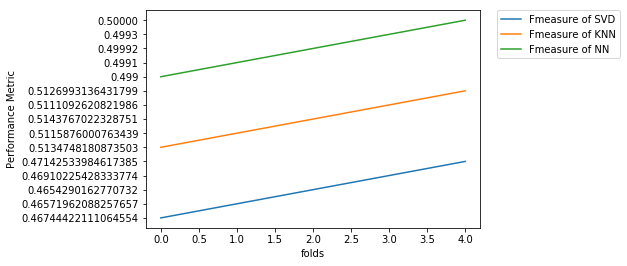

In [20]:
import matplotlib.pyplot as plt
training_epochs =5
iterations = list(range(training_epochs))
modelPrediction = plt.plot(FSVD,label='Fmeasure of SVD')
modelPrediction = plt.plot(fKNN,label='Fmeasure of KNN')
print(fmeasure1)
modelPrediction = plt.plot(fmeasure1,label='Fmeasure of NN')
modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('Performance Metric')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
Y1=numpy.asarray(test.rating)
Y2=np.transpose(Y1)
print(Y2)
x= model2.predict([test.user_id, test.book_id])
X1= x.transpose()[0]
X2 = numpy.rint(X1)
print(X2.astype(int))
precision1 = precision_score(Y2, X2.astype(int), average='micro')
print(precision1)

recall1 = recall_score(Y2, X2.astype(int), average='micro')
print(recall1)

[5 4 3 ... 4 3 4]
[5 4 3 ... 4 3 4]
0.47096427218168263
0.47096427218168263


In [22]:
x= model2.predict([test.user_id, test.book_id])

model2.evaluate([test.user_id, test.book_id], test.rating)

245439/245439 [==============================] - 6s 24us/step


[0.8364472527968179, 0.5, 0.5, 0.4999999403953552]

In [23]:
predictions = model2.predict([test.user_id.head(10), test.book_id.head(10)])
predictions[:10]
'''
predictions2 = model2.test([test.user_id.head(10), test.book_id.head(10)])
predictions2.head(10)

'''



[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[5.081886] 5
[3.6627026] 4
[3.2617826] 3
[4.0021644] 5
[3.262678] 3
[4.338704] 3
[3.6655686] 3
[4.7611337] 4
[4.1038074] 3
[4.176169] 5


[None, None, None, None, None, None, None, None, None, None]

<a id="4"></a> 
## Visualizing Embeddings
Embeddings are weights that are learned to represent some specific variable like books and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [24]:
# Extract embeddings
book_em = model2.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [25]:
book_em_weights[:5]

array([[ 0.01795897,  0.01882353, -0.0177981 , -0.00351046,  0.01436437],
       [-0.303127  , -0.22942682,  0.28112364, -0.3834272 , -0.361975  ],
       [-0.3063271 ,  0.07954627,  0.22817713, -0.2891299 , -0.17471924],
       [ 0.38744992,  0.18056288, -0.30139488,  0.35427073,  0.32537213],
       [-0.42746323, -0.06617498,  0.33981895, -0.4935629 , -0.4142606 ]],
      dtype=float32)

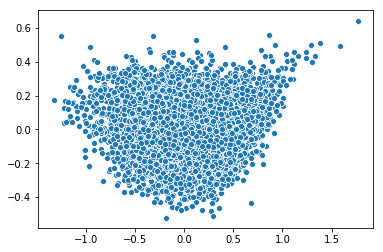

In [26]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [27]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

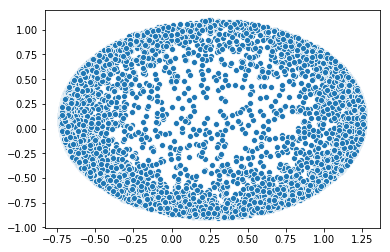

In [28]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.007s...
[t-SNE] Computed neighbors for 10001 samples in 0.588s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.080196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.399841
[t-SNE] KL

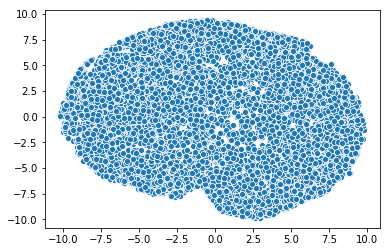

In [30]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

<a id="5"></a> 
## Making Recommendations

In [31]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [32]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [33]:
predictions = model2.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([5206, 3627, 8945,  861, 9565])

In [34]:
predictions
#predictions.shape

array([4.0568423, 3.9059806, 3.0475883, ..., 3.9300704, 3.6696522,
       3.785378 ], dtype=float32)

In [35]:
predictions.shape

(10000,)

In [36]:
# print predicted scores
predictions[recommended_book_ids]

array([4.684493 , 4.6787677, 4.6433096, 4.6357117, 4.614303 ],
      dtype=float32)

In [37]:
books = pd.read_csv('../input/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [38]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
860,861,15745950,15745950,21436019,58,1476712980,9.781477e+12,Jamie McGuire,2013.0,Walking Disaster,"Walking Disaster (Beautiful, #2)",eng,4.23,134022,145114,11348,2597,5841,20243,42657,73776,https://images.gr-assets.com/books/1352338368m...,https://images.gr-assets.com/books/1352338368s...
3626,3627,7592279,7592279,9985502,37,1741664489,9.781742e+12,John Flanagan,2011.0,NaN,"The Emperor of Nihon-Ja (Ranger's Apprentice, ...",eng,4.42,29397,33357,1089,226,618,3569,9564,19380,https://images.gr-assets.com/books/1446448563m...,https://images.gr-assets.com/books/1446448563s...
5205,5206,13066,13066,2257006,31,446695688,9.780447e+12,Carl Hiaasen,2000.0,Sick Puppy,Sick Puppy,eng,3.88,18248,19594,1069,193,861,5077,8434,5029,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8944,8945,32529,32529,3214115,40,752848267,9.780753e+12,Lisa Gardner,2001.0,The Next Accident,"The Next Accident (Quincy & Rainie, #3)",en-US,4.16,11261,13328,513,49,231,2323,5612,5113,https://images.gr-assets.com/books/1348816896m...,https://images.gr-assets.com/books/1348816896s...
9564,9565,24819476,24819476,44460264,18,316261130,9.780316e+12,Elin Hilderbrand,2015.0,Winter Stroll,Winter Stroll (Winter #2),NaN,3.70,8397,9754,979,133,640,3133,3971,1877,https://images.gr-assets.com/books/1431957489m...,https://images.gr-assets.com/books/1431957489s...


In [39]:
user




array([1, 1, 1, ..., 1, 1, 1])

In [40]:

predictionsKNN = collabKNN.predict(uid=24497, iid=4037)
predictionsKNN

Prediction(uid=24497, iid=4037, r_ui=None, est=3.75, details={'actual_k': 4, 'was_impossible': False})

In [41]:
books = pd.read_csv('../input/books.csv')
ratings = pd.read_csv('../input/ratings.csv')
book = books[['book_id','authors','title']]
books_data = pd.merge(book, ratings, on='book_id')

def recommendation(user_id):
    user = book.copy()
    already_read = books_data[books_data['user_id'] == user_id]['book_id'].unique()
    user = user.reset_index()
    user = user[~user['book_id'].isin(already_read)]
    user['Estimate_Score']=user['book_id'].apply(lambda x: funkSVD.predict(user_id, x).est)
    user = user.drop('book_id', axis = 1)
    user = user.sort_values('Estimate_Score', ascending=False)
    return user.head(10)

In [42]:
x= recommendation(2)
Y= x.values.tolist()
print(Y)

[[4871, 'Tom Robbins', 'Villa Incognito', 4.502089509684946], [6662, 'Janet Briggs, Beth Wittlinger', 'The Taste of Home Cookbook', 4.487152461990495], [1298, 'Tom Robbins', 'Still Life with Woodpecker', 4.461080031246072], [662, 'Howard Zinn', "A People's History of the United States", 4.434769868330922], [147, 'Tracy Chevalier', 'Girl with a Pearl Earring', 4.408340638108692], [59, 'Mark Haddon', 'The Curious Incident of the Dog in the Night-Time', 4.399482155770437], [3140, 'Ian McEwan', 'Amsterdam', 4.36094120342045], [4982, 'Graham Greene', 'The Heart of the Matter', 4.357162128719571], [5793, 'Loung Ung', 'First They Killed My Father: A Daughter of Cambodia Remembers', 4.3466640353698835], [8837, 'James Hilton', 'Lost Horizon', 4.346287308684555]]
